#### what's the problem?
1. high dimensional features
- as in the output is determined by a (complex?) function involving a large number of features
2. small number of samples of the "positive" "class"
- large number of samples of the other "class"
- problem is that this is a regression problem, no such thing as classes
- well, actually, in real life it is a classification problem
3. source domain is available where
- the source has a large number of samples of both classes available
4. target domain also have imprecise estimates, whereas source has precise estimates

#### so how can the source help?
1. suppose src = tgt
- in this case, we can get more instances of the rare class
2. suppose src != tgt
- in this case, we hope that tgt rare classes resemble src rare classes closely enough to help

#### so describe the simple problem where this works well
1. tgt samples where one class is rare
2. both src and tgt high dimensional
3. src and tgt not that different

##### what does "not that different" mean?
options:
1. some fraction of the features are the same, while the others differ
- the problem with this is that it assumes independence between features
- and independence in how the features differ

##### what does "different" mean?
1. translated by some amount
2. stretched by some amount
3. rotated by some amount

#### why should DANN help?
1. shared feature space
- in reality, the benefit is not obvious, and I would say I should just try it out and see what helps
2. does it make sense to apply the penalty only to the source data?
- I think it may
- basically you want to target data 
3. suppose that the target data has no instances of the positive class?
- oh yeah, there it is
- ok so the results should show relative performance as the positive class availability changes



In [50]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import sklearn.datasets
import sklearn.linear_model
import tensorflow as tf

import dann
import domain_adaptation_dataset

In [2]:
def generate_data(n_samples, dim, offset=0., threshold=):
    x = np.random.randn(n_samples, dim) * .5
    x[:,:dim // 2] += offset
    y_star = np.sum(x, axis=-1)
    y_star -= offset * dim // 2
    one_idxs = np.where(y_star > 0)[0]
    zero_idxs = np.where(y_star < 0)[0]
    y = np.zeros((n_samples, 2))
    y[one_idxs, 1] = 1
    y[zero_idxs, 0] = 1
    return x, y
    

In [44]:
n_samples = 1000
input_dim = 100
batch_size = 100
xs, ys = generate_data(n_samples, input_dim)
xs_val, ys_val = generate_data(n_samples, input_dim)
xt, yt = generate_data(n_samples // 5, input_dim, offset=2.)
xt_val, yt_val = generate_data(n_samples, input_dim, offset=2.)

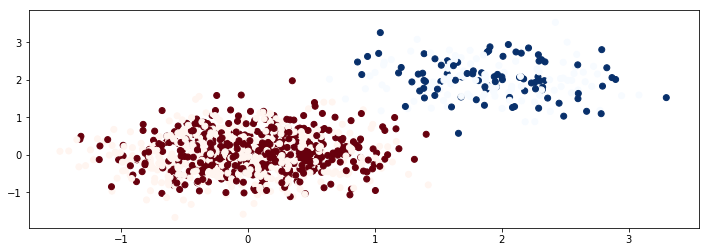

In [45]:
plt.figure(figsize=(12,4))
plt.scatter(xs[:,0], xs[:,1], c=np.argmax(ys, axis=-1), cmap='Reds')
plt.scatter(xt[:,0], xt[:,1], c=np.argmax(yt, axis=-1), cmap='Blues')

In [46]:
dataset = domain_adaptation_dataset.DomainAdaptationDataset(xs, ys, xt, yt, batch_size=100)
val_dataset = domain_adaptation_dataset.DomainAdaptationDataset(xs_val, ys_val, xt_val, yt_val, batch_size=100)

In [47]:
n_updates = 1000

tf.reset_default_graph()
sess = tf.InteractiveSession()

model = dann.DANN(
    input_dim=input_dim, 
    output_dim=2,  
    lambda_final=1.,
    lambda_steps=500,
    dropout_keep_prob=.5,
    encoder_hidden_layer_dims=(128,64,64),
    classifier_hidden_layer_dims=(),
    src_only_adversarial=True
)
sess.run(tf.global_variables_initializer())

updates_per_epoch = (n_samples / batch_size)
n_epochs = int(n_updates // updates_per_epoch)

In [48]:
model.train(dataset, n_epochs=n_epochs)

 training: True epoch: 100 / 100 loss: 1.0719 domain accuracy: 0.5200

In [49]:
stats = model.evaluate(xs,ys,np.zeros(n_samples))
print(stats['roc_auc'])
stats = model.evaluate(xt,yt,np.zeros(n_samples))
print(stats['roc_auc'])
stats = model.evaluate(xs_val,ys_val,np.zeros(n_samples))
print(stats['roc_auc'])
stats = model.evaluate(xt_val,yt_val,np.zeros(n_samples))
print(stats['roc_auc'])

0.929689969945
0.979231777397
0.855014331236
0.772505644425


In [ ]:
0.979109889186
0.786358173077
0.972584052104
0.753046388368